## 0. Importing Libraries

In [18]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import pandas as pd
assert pd.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

import seaborn as sns

## 1. Loading Data

In [174]:
features, target = load_svmlight_file('diabetes.txt')

features = features.toarray()
target = target.reshape(target.shape[0],1)

print(f"Size of features: {features.shape}")
print(f"Size of target: {target.shape}")

Size of features: (768, 8)
Size of target: (768, 1)


In [175]:
pd.DataFrame(features).describe()

,0,1,2,3,4,5,6,7
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591971
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858455,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409547,0.311475,-0.353535,-0.699173,0.090909,-0.531811,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.Exploratory data analysis

In [176]:
# split the dataset
X_bigtrain, X_test, y_bigtrain, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_bigtrain, y_bigtrain , test_size=0.2, random_state=42, stratify=y_bigtrain)


print(f'Shapes of sets are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes of sets are [(491, 8), (491, 1), (154, 8), (154, 1), (123, 8), (123, 1)]


In [5]:
## EDA 
colnames=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','label']

df = pd.DataFrame(features)
df['Outcome']=target

df.columns=colnames

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,label
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0


In [6]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
def hist_plot(features, Nrows, Ncols):

    fig, axes = plt.subplots(Nrows, Ncols, figsize=(20, 20))

    for row in range(Nrows):
        for col in range(Ncols):
            feature = features[row * Ncols + col]
            sns.histplot(data=df, x=feature, hue="label", bins='auto', kde=True, ax=axes[row,col], edgecolor=None)
            # sns.boxplot(y=feature,x='label',data=df, ax=axes[row,col])

    plt.show()   

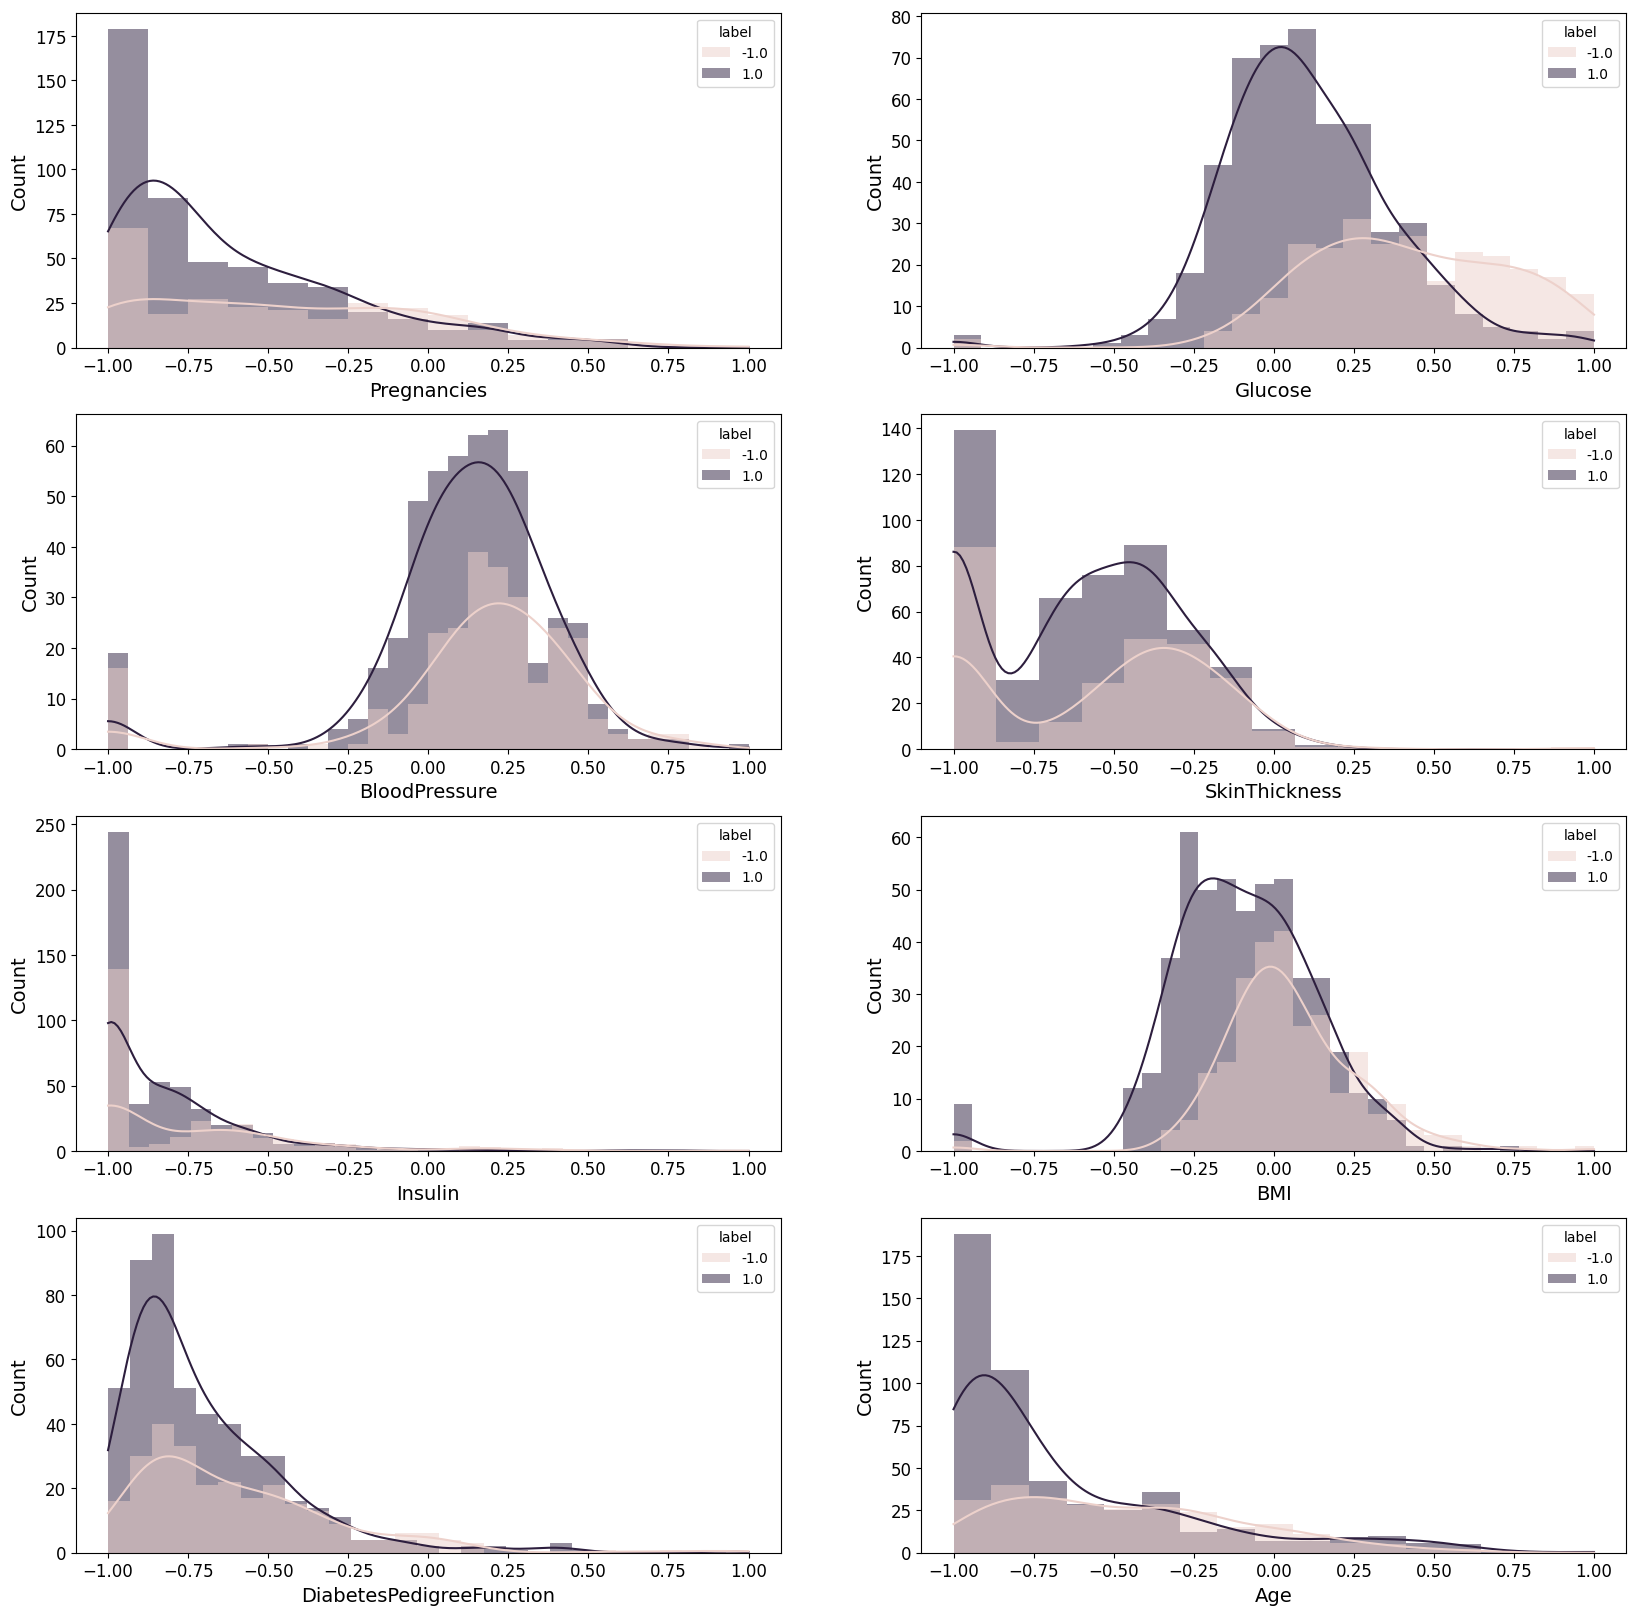

In [7]:
hist_plot(colnames,4,2)

## 3.Model Implement

### Check linear separability

In [194]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svmModel = SVC(C=2**32, random_state=42, kernel="linear")
trainedSvmModel = svmModel.fit(X_train, y_train.reshape(y_train.shape[0],))
predictions = svmModel.predict(X_train)

accuracy = accuracy_score(y_train, predictions)
print("Linear separability test accuracy: ", accuracy)

Linear separability test accuracy:  0.7637474541751528


### Baseline perceptron

In [177]:
from sklearn.linear_model import Perceptron

comparison_model = Perceptron(eta0=0.01, max_iter=20)


# Train model (20 epochs)
fitted_model = comparison_model.fit(X_train,y_train.reshape((y_train.shape[0],)))
predictions = fitted_model.predict(X_val)

print("Validation accuracy = ", accuracy_score(y_val, predictions))

Validation accuracy =  0.7642276422764228


###  Perceptron Implementation

In [180]:
class Perceptron:
    def __init__(self, X_train, y_train, X_val, y_val, lr = 1,loss_type="zero-one", seed = -1, bias = False, 
                 weight_val = 0, earlyStopping = -1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.lr = lr
        self.loss_type = loss_type
        self.seed = seed
        self.bias = bias
        self.weight_val = weight_val
        self.earlyStopping= earlyStopping
        self.originalEarlyStopping = self.earlyStopping
        self.weightVectors = []
        self.weights = self.initializeWeights()      
        self.trainingAccuracies = []
        self.validationAccuracies = []
        self.weightVectors = []
        self.trainingLosses = []
        self.validationLosses = []
        self.testLosses = []        
        self.currentBestValAccuracy = 0
        self.currentBestIndex = 0
        self.predictions = np.array([])
               
    def _biasColumn(self, array):    
        return np.append(np.ones(array.shape[0]).reshape(array.shape[0],1), array, axis= 1)

               
    def initializeWeights(self):
        if self.seed >= 0:
            np.random.seed(self.seed)

        if self.weight_val == 1:
            if self.bias:
                weights = np.ones(self.X_train.shape[1]+1)
            else:
                weights = np.ones(self.X_train.shape[1])
        elif self.weight_val == 0:
            if self.bias:
                weights = np.zeros(self.X_train.shape[1]+1)
            else:
                weights = np.zeros(self.X_train.shape[1])
        else:
            if self.bias:
                weights = np.random.rand(self.X_train.shape[1]+1)
            else:
                weights = np.random.rand(self.X_train.shape[1])

        if self.bias:
            self.X_train = self._biasColumn(self.X_train)
            self.X_val = self._biasColumn(self.X_val)          
            
        return weights
    
    
    def train(self, epochs = 10, verbose = True, showPlots = True):
        
        self.currentBestValAccuracy = 0
        for i in range(epochs):
            
            sum = 0

            for X, y in zip(self.X_train, self.y_train):
                if self.loss_type == "zero-one": 
                    sum += y * X * (self._base_step_func(X, y, self.weights))
                elif self.loss_type == "perceptron": # Loss for Perceptron Loss
                    sum += y * X * max(0, - y * (np.dot(X, self.weights)))
                elif self.loss_type == "hinge": # Loss for Hinge Loss
                    sum += y * X * max(0, 1 - y * (np.dot(X, self.weights)))    
                else:
                    raise Exception("Wrong Loss Function!") 
                # sum = sum + (y * X * (self._base_step_func(X, y, self.weights)))

            self.weights += self.lr * sum

            self.weightVectors.append(self.weights)
    
            # Store loss value
            self._storeValLossAndAccuracy()
            self._storeTrainLossAndAccuracy()
            
            # Display epoch by epoch results
            if verbose:
                print("Epoch {}:".format(i + 1))
                print("Training Acc:", self.trainingAccuracies[i])
                print("Validation Acc:", self.validationAccuracies[i])
                print("Training Loss:", self.trainingLosses[i])
                print("Validation Loss:", self.validationLosses[i], "\n")
                
            if self.earlyStopping == 0:
                print("Early stopped at epoch", (i + 1))
                break

               
        if showPlots:
            # Plot graphs of loss and accuracy
            plt.title("Loss curves")
            plt.plot(np.arange(0, len(self.trainingLosses)), self.trainingLosses, label="Training loss")
            plt.plot(np.arange(0, len(self.validationLosses)),self.validationLosses, label="Validation loss")
            plt.xlabel("Number of epochs")
            plt.ylabel("Loss")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
            
            plt.title("Accuracy curves")
            plt.plot(range(len(self.trainingAccuracies)),
                    self.trainingAccuracies, label="Training Accuracy")
            plt.plot(range(len(self.validationAccuracies)),
                    self.validationAccuracies, label="Validation Accuracy")
            plt.xlabel("Number of epochs")
            plt.ylabel("Accuracy")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
                
    def _base_step_func(self, feature, label, weights): # Threshold function
        step = (1 if np.dot(feature, weights) * label <= 0 else 0)
        return step

    def _storeValLossAndAccuracy(self):

        loss = self._loss_func(self.loss_type, self.X_val, self.y_val, self.weights)
        pred, accuracy = self._pred_accuracy(self.X_val, self.y_val, self.weights)
        
        self.validationLosses.append(loss)
        self.validationAccuracies.append(accuracy)
        
        # Store best accuracy
        if accuracy >= self.currentBestValAccuracy:
            self.currentBestValAccuracy = accuracy
            self.currentBestIndex = len(self.validationAccuracies) - 1
            self.earlyStopping = self.originalEarlyStopping
        else:
            self.earlyStopping -= 1
        
    def _storeTrainLossAndAccuracy(self):
        
        loss = self._loss_func(self.loss_type, self.X_train, self.y_train, self.weights)
        pred, accuracy = self._pred_accuracy(self.X_train, self.y_train, self.weights)
        
        self.trainingLosses.append(loss)
        self.trainingAccuracies.append(accuracy)
            
    def predict(self, X):
        predictions = np.sign(np.matmul(X, self.weights))
        return predictions
    
    def calc_accuracy(self, actual, predictions):
        count = 0
        length = len(actual)
        for i in range(length):
            if actual[i] == predictions[i]:
                count += 1
        return count / length
    
    # Claculate accuracy
    def _pred_accuracy(self, features, target, weights): # Function to find accuracy score for predictions
        
        preds = np.sign(np.dot(features, weights))
        cnt = 0
        for pred, t in zip(preds, target):
            if pred == t:
                cnt += 1  
        accuracy = cnt/features.shape[0]
        return preds, accuracy
    
    # Claculate loss for different loss types
    def _loss_func(self, loss_type, features, target, weights): 

        sum_loss = 0
        for X, y in zip(features, target):

            if loss_type == "zero-one": 
                sum_loss += self._base_step_func(X, y, weights)
            elif loss_type == "perceptron": # Loss for Perceptron Loss
                sum_loss += max(0, - y * (np.dot(X, weights)))
            elif loss_type == "hinge": # Loss for Hinge Loss
                sum_loss += max(0, 1 - y * (np.dot(X, weights)))    
            else:
                raise Exception("Wrong Loss Function!")   


        return sum_loss/features.shape[0]
    
    def evaluate(self, X, y):
        predictions = np.array([])
        if self.bias:
            X_new = self._biasColumn(X)
            predictions = self.predict(X_new)
        else:
            predictions = self.predict(X)
        self.predictions = predictions
        return self.calc_accuracy(y, predictions)
    
    def getBestParameters(self):
        return (self.weightVectors[self.currentBestIndex],
                self.trainingAccuracies[self.currentBestIndex],
                self.validationAccuracies[self.currentBestIndex])
    
    def setBestWeights(self):
        self.weights = self.weightVectors[self.currentBestIndex]

    def showBestAccuracy(self):
        best_accuracy = self.validationAccuracies[self.currentBestIndex]
        print(f"----- Best Accuracy is {best_accuracy*100:.2f} % ------")    
        

Epoch 1:
Training Acc: 0.6496945010183299
Validation Acc: 0.6504065040650406
Training Loss: 0.35030549898167007
Validation Loss: 0.34959349593495936 

Epoch 2:
Training Acc: 0.7474541751527495
Validation Acc: 0.7560975609756098
Training Loss: 0.2525458248472505
Validation Loss: 0.24390243902439024 

Epoch 3:
Training Acc: 0.35234215885947046
Validation Acc: 0.34146341463414637
Training Loss: 0.6476578411405295
Validation Loss: 0.6585365853658537 

Epoch 4:
Training Acc: 0.6517311608961304
Validation Acc: 0.6504065040650406
Training Loss: 0.34826883910386963
Validation Loss: 0.34959349593495936 

Epoch 5:
Training Acc: 0.6639511201629328
Validation Acc: 0.6991869918699187
Training Loss: 0.3360488798370672
Validation Loss: 0.3008130081300813 

Epoch 6:
Training Acc: 0.5865580448065173
Validation Acc: 0.5853658536585366
Training Loss: 0.4134419551934827
Validation Loss: 0.4146341463414634 

Epoch 7:
Training Acc: 0.6619144602851323
Validation Acc: 0.6991869918699187
Training Loss: 0.33808

Epoch 9:
Training Acc: 0.7739307535641547
Validation Acc: 0.7479674796747967
Training Loss: 0.22606924643584522
Validation Loss: 0.25203252032520324 

Epoch 10:
Training Acc: 0.570264765784114
Validation Acc: 0.5284552845528455
Training Loss: 0.42973523421588594
Validation Loss: 0.4715447154471545 

Epoch 11:
Training Acc: 0.6558044806517311
Validation Acc: 0.6910569105691057
Training Loss: 0.34419551934826886
Validation Loss: 0.3089430894308943 

Epoch 12:
Training Acc: 0.7739307535641547
Validation Acc: 0.7560975609756098
Training Loss: 0.22606924643584522
Validation Loss: 0.24390243902439024 

Epoch 13:
Training Acc: 0.7617107942973523
Validation Acc: 0.6829268292682927
Training Loss: 0.23828920570264767
Validation Loss: 0.3170731707317073 

Epoch 14:
Training Acc: 0.769857433808554
Validation Acc: 0.7642276422764228
Training Loss: 0.23014256619144602
Validation Loss: 0.23577235772357724 

Epoch 15:
Training Acc: 0.5417515274949084
Validation Acc: 0.5528455284552846
Training Loss: 0

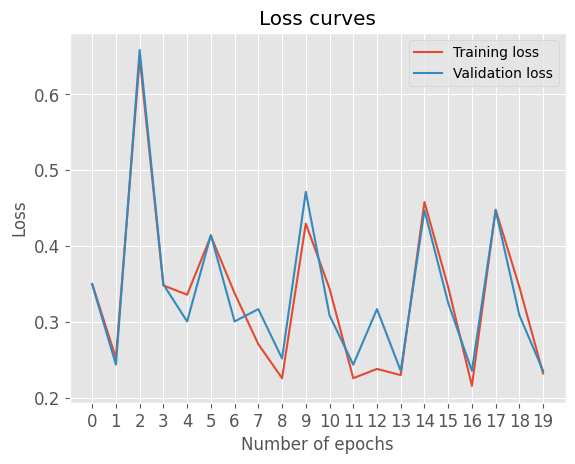

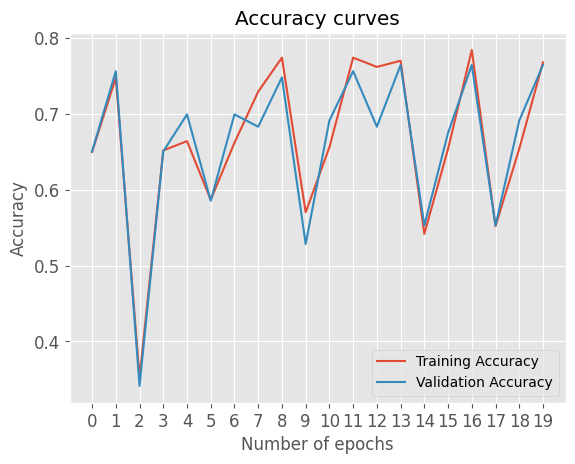

----- Best Accuracy is 76.42 % ------


In [183]:
# Create a simple perceptron 
perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=0.01, loss_type="zero-one", bias=False,
                        seed=200, earlyStopping=20)
perceptron.train(epochs=20, verbose=True)

# Choose the best model 
perceptron.setBestWeights()

# show best accuracy
perceptron.showBestAccuracy()

###  Adaline Implementation

In [42]:
class Adaline(Perceptron):
    def train(self, epochs = 10, verbose = True, showPlots = True):

        self.currentBestValAccuracy = 0
        j = 0
        for i in range(epochs):
            
            sum = 0
            for X, y in zip(self.X_train, self.y_train):
                prod = np.dot(X, self.weights)
                # sum = sum + (y - prod) * X
                # sum = sum + (y * X * (self._base_step_func(X, y, self.weights)))
                self.weights += (self.lr * 4 * (y - prod) * X)
                self.weightVectors.append(self.weights)
    
                # Store loss value
                self._storeValLossAndAccuracy()
                self._storeTrainLossAndAccuracy()
            
                # Display epoch by epoch results
                if verbose:
                    print("Epoch {}:".format(j + 1))
                    print("Training Acc:", self.trainingAccuracies[i])
                    print("Validation Acc:", self.validationAccuracies[i])
                    print("Training Loss:", self.trainingLosses[i])
                    print("Validation Loss:", self.validationLosses[i], "\n")
                
                if self.earlyStopping == 0:
                    print("Early stopped at epoch", (i + 1))
                    break
                j += 1

        if showPlots:
            plt.title("Loss curves")
            plt.plot(np.arange(0, len(self.trainingAccuracies)), self.trainingLosses, label="Training loss")
            plt.plot(np.arange(0, len(self.trainingAccuracies)), self.validationLosses, label="Validation loss")
            plt.xlabel("Number of epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            
            plt.title("Accuracy curves")
            plt.plot(np.arange(0, len(self.trainingAccuracies)), self.trainingAccuracies, label = "Training Accuracy")
            plt.plot(np.arange(0, len(self.trainingAccuracies)), self.validationAccuracies, label = "Validation Accuracy")
            plt.xlabel("Number of epochs")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show 
        

## 4. Experiments and analysis

### 4.0 Verifying perceptron works

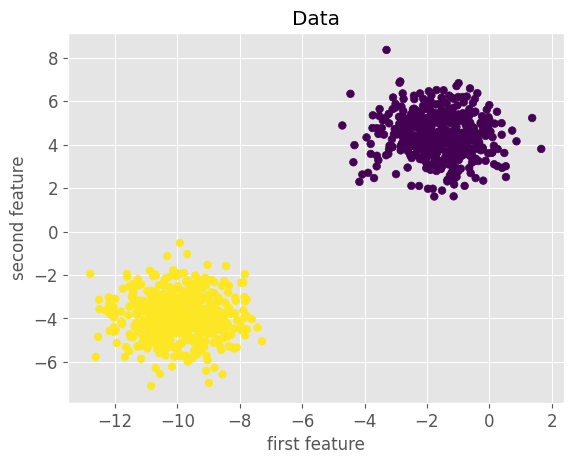

In [115]:
from sklearn.datasets import make_blobs

sample_X, sample_y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1, random_state=1)
np.place(sample_y, sample_y==0, [-1])
sample_y = sample_y.reshape((sample_y.shape[0], 1))


# plot the classification data
plt.style.use("ggplot")
plt.figure()
plt.title("Data")
plt.xlabel('first feature')
plt.ylabel('second feature')
plt.scatter(sample_X[:, 0], sample_X[:, 1], marker="o", c=sample_y[:, 0], s=30)
plt.show()


In [116]:
X_bigtrain_sample, X_test_sample, y_bigtrain_sample, y_test_sample = train_test_split(sample_X, sample_y, test_size=0.2, random_state=42)
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_bigtrain_sample, y_bigtrain_sample, test_size=0.2, random_state=42)

Epoch 1:
Training Acc: 0.9859375
Validation Acc: 0.98125
Training Loss: 0.0140625
Validation Loss: 0.01875 

Epoch 2:
Training Acc: 0.9859375
Validation Acc: 0.98125
Training Loss: 0.0140625
Validation Loss: 0.01875 

Epoch 3:
Training Acc: 0.990625
Validation Acc: 0.98125
Training Loss: 0.009375
Validation Loss: 0.01875 

Epoch 4:
Training Acc: 0.99375
Validation Acc: 0.98125
Training Loss: 0.00625
Validation Loss: 0.01875 

Epoch 5:
Training Acc: 0.99375
Validation Acc: 0.98125
Training Loss: 0.00625
Validation Loss: 0.01875 

Epoch 6:
Training Acc: 0.99375
Validation Acc: 0.98125
Training Loss: 0.00625
Validation Loss: 0.01875 

Epoch 7:
Training Acc: 0.9953125
Validation Acc: 0.98125
Training Loss: 0.0046875
Validation Loss: 0.01875 

Epoch 8:
Training Acc: 0.9953125
Validation Acc: 0.98125
Training Loss: 0.0046875
Validation Loss: 0.01875 

Epoch 9:
Training Acc: 0.9953125
Validation Acc: 0.98125
Training Loss: 0.0046875
Validation Loss: 0.01875 

Epoch 10:
Training Acc: 0.9953125

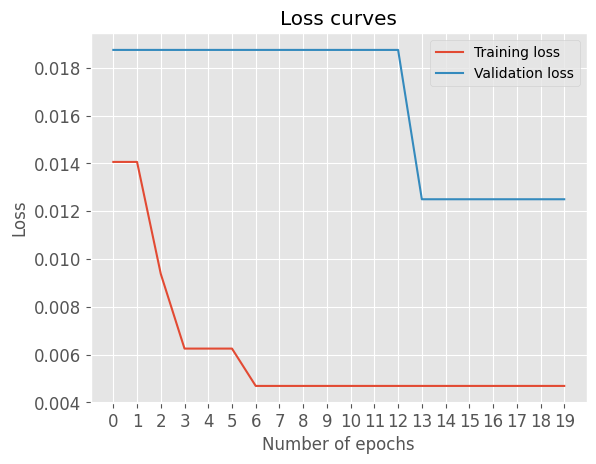

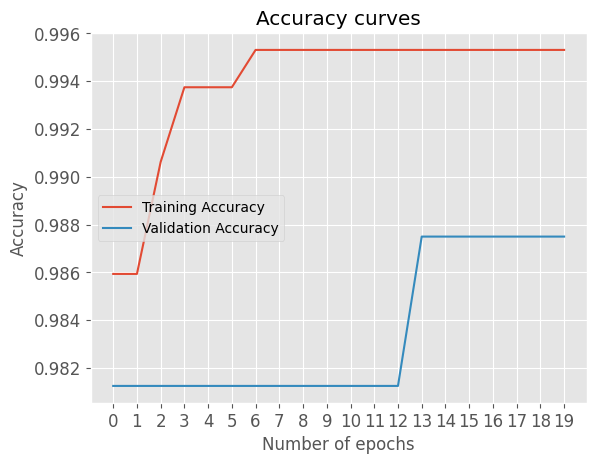

----- Best Accuracy is 98.75 % ------


In [117]:
# Create a simple perceptron 
perceptron = Perceptron(X_train_sample, y_train_sample, X_val_sample, y_val_sample, lr=0.01, loss_type="zero-one", bias=False,
                        seed=200, earlyStopping=20)
perceptron.train(epochs=20, verbose=True)

# Choose the best model 
perceptron.setBestWeights()

# show best accuracy
perceptron.showBestAccuracy()

### 4.1 Experiments with bias and weights

In [185]:
bias_list = [True, False]
weight_list = [0,1,2]
results = []

for i in bias_list:
    for j in weight_list:
        perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=0.01, loss_type="zero-one", bias=i,
                        seed=200, weight_val = j, earlyStopping=-1)        
        perceptron.train(epochs=50, verbose=False, showPlots=False)
        bestTrainAccuracy = perceptron.getBestParameters()[1]
        bestValAccuracy = perceptron.getBestParameters()[2]
        results.append((bestValAccuracy, bestTrainAccuracy, i, j))

result = pd.DataFrame(results).sort_values(by=[0], ascending=False).rename(columns={0: "Validation Accuracy",
                                    1: "Training Accuracy",
                                    2: "bias",
                                    3: "weight"
                                    })

result

,Validation Accuracy,Training Accuracy,bias,weight
4,0.780488,0.773931,False,1
5,0.780488,0.775967,False,2
0,0.772358,0.773931,True,0
1,0.772358,0.769857,True,1
2,0.772358,0.778004,True,2
3,0.772358,0.757637,False,0


### 4.2 Hyperparameter tuning

In [187]:
loss_types = ["zero-one", "perceptron", "hinge"]
learningRates = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10]
patienceList = [10, 20]
results = []

for loss in loss_types:
    for lr in learningRates:
        for patience in patienceList:
            perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=lr, loss_type=loss, bias=False,
                        seed=200, weight_val = 2, earlyStopping=patience)
            perceptron.train(epochs=50, verbose=False, showPlots=False)

            # Best parameters
            bestTrainAccuracy = perceptron.getBestParameters()[1]
            bestValAccuracy = perceptron.getBestParameters()[2]
            results.append((bestValAccuracy, bestTrainAccuracy, lr, loss, patience))
        
result = pd.DataFrame(results).sort_values(by=[0], ascending=False).rename(columns=
                                   {0:"Validation Accuracy",
                                    1:"Training Accuracy",
                                    2:"Learning rate",
                                    3:"Loss",
                                    4:"Patience"})

result

Early stopped at epoch 14
Early stopped at epoch 24
Early stopped at epoch 19
Early stopped at epoch 13
Early stopped at epoch 13
Early stopped at epoch 33
Early stopped at epoch 43
Early stopped at epoch 12
Early stopped at epoch 22
Early stopped at epoch 26
Early stopped at epoch 36
Early stopped at epoch 12
Early stopped at epoch 46


,Validation Accuracy,Training Accuracy,Learning rate,Loss,Patience
32,0.788618,0.773931,0.00100,hinge,10
33,0.788618,0.773931,0.00100,hinge,20
6,0.780488,0.775967,0.01000,zero-one,10
7,0.780488,0.775967,0.01000,zero-one,20
13,0.780488,0.780041,10.00000,zero-one,20
9,0.772358,0.769857,0.10000,zero-one,20
11,0.772358,0.773931,1.00000,zero-one,20
4,0.756098,0.747454,0.00100,zero-one,10
5,0.756098,0.747454,0.00100,zero-one,20
8,0.756098,0.755601,0.10000,zero-one,10


### 4.3 Experiments with Adaline

Epoch 1:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 2:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 3:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 4:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 5:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 6:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 7:
Training Acc: 0.34623217922606925
Validation Acc: 0.3170731707317073
Training Loss: [1.93984872]
Validation Loss: [2.00986911] 

Epoch 8:
Training Acc: 0.346232179

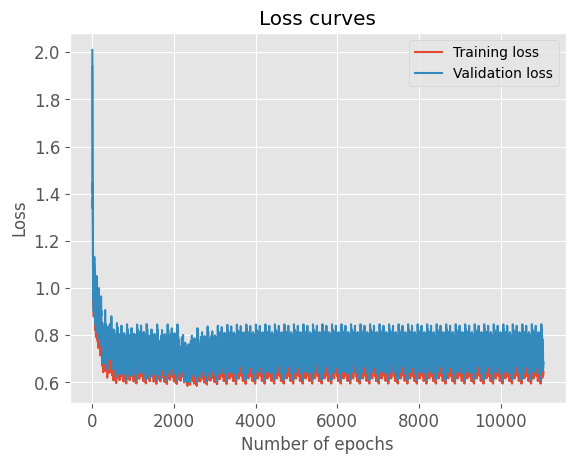

----- Best Accuracy is 79.67 % ------


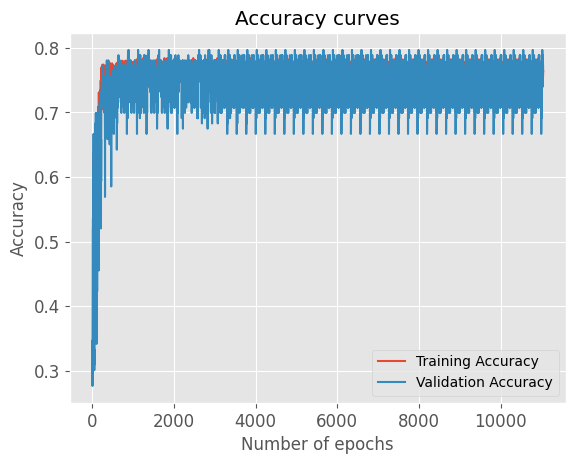

In [188]:
# Create a simple adaline model
adaline = Adaline(X_train, y_train, X_val, y_val, lr=0.01, loss_type='hinge', bias=False,
                        seed=200, weight_val = 2, earlyStopping=20)

adaline.train(epochs=50, verbose=True)

# Set best weights
adaline.showBestAccuracy()

## 5.Choose the bese model

Test accuracy: 70.78


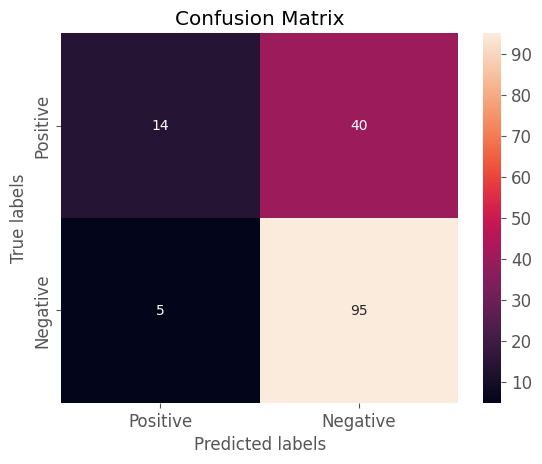

Sensitivity = 0.95
Specificity = 0.25925925925925924


In [193]:
#  choose adaline as the best model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

testAccuracy = adaline.evaluate(X_test, y_test)
print(f"Test accuracy: {testAccuracy*100:.2f}")

predictions = adaline.predictions
confMat = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confMat.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

ax= plt.subplot()
sns.heatmap(confMat, annot=True, fmt='g', ax=ax)
plt.title('Confusion Matrix')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);
plt.show()

print("Sensitivity =", sensitivity)
print("Specificity =", specificity)
